# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")

all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


## Predictions with markers

In [3]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [4]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [5]:
from model_nb_classifier import ModelNBClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier



def train_and_predict(df, min_df=None):
    m = ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0", min_df=min_df, trigger_words=ptm_trigger_words)
    m.train(df["x"], df["y"])
    return m, m.predict(df["x"])[0]



In [6]:
def print_report(actual, pred, latex=True, labels=None):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    print(sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=False,
                                            labels=labels,zero_division=0)
     )
    
    if latex:
        
        d = sklearn.metrics.classification_report(actual,
                                                pred,
                                                output_dict=True,
                                                labels=[0,1, 2, 3, 4, 5, 6],zero_division=0)
        return pd.DataFrame(d).T

In [7]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [8]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [10]:
m = ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0", trigger_words=ptm_trigger_words)

## Train GT Train predictions

In [11]:
df_train = pd.read_json(trainfile, orient="records")
m.train(df_train["x"], df_train["y"])
train_pred = m.predict(df_train["x"])[0]

print_report(df_train["y"], train_pred, False, pos_labels)

print_report(df_train["y"], train_pred, False, all_labels)



(1305, 11)
(1305, 11)
              precision    recall  f1-score   support

           1       0.73      0.51      0.60       139
           2       0.76      0.57      0.65        28
           3       0.62      0.50      0.56        10
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       1.00      0.50      0.67         2

   micro avg       0.73      0.49      0.59       189
   macro avg       0.52      0.35      0.41       189
weighted avg       0.69      0.49      0.58       189

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1116
           1       0.73      0.51      0.60       139
           2       0.76      0.57      0.65        28
           3       0.62      0.50      0.56        10
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       1.00      0.50      0.67         2

 

In [12]:
get_top_discrimintary_keywords(m, 4)


[('protpart1', -3.301113923105173),
 ('protpart0', -3.7806870033670594),
 ('prtig0', -4.399726211773283),
 ('protein', -4.473834183927005),
 ('degradation', -4.553876891600542),
 ('proteins', -4.640888268590171),
 ('cell', -4.841558964052322),
 ('prtig1', -4.959341999708705),
 ('transcription', -4.959341999708705),
 ('cells', -4.959341999708705),
 ('expression', -5.092873392333228),
 ('dependent', -5.092873392333228),
 ('dna', -5.247024072160487),
 ('ubiquitin', -5.247024072160487),
 ('depletion', -5.429345628954441),
 ('suppressor', -5.429345628954441),
 ('human', -5.429345628954441),
 ('protpart1 degradation', -5.429345628954441),
 ('mediated', -5.429345628954441),
 ('phase', -5.429345628954441),
 ('ubiquitination', -5.429345628954441),
 ('activity', -5.429345628954441),
 ('pathway', -5.652489180268651),
 ('response', -5.652489180268651),
 ('results', -5.652489180268651),
 ('function', -5.652489180268651),
 ('protpart0 protpart1', -5.652489180268651),
 ('regulation', -5.6524891802686

## Val GT predictions


In [13]:
df_val = pd.read_json(valfile, orient="records")
val_pred = m.predict(df_val["x"])[0]
print_report(df_val["y"], val_pred, False, pos_labels)

print_report(df_val["y"], val_pred, False, all_labels)




(200, 11)
              precision    recall  f1-score   support

           1       0.57      0.38      0.46        21
           2       0.30      0.30      0.30        10
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.46      0.32      0.38        34
   macro avg       0.15      0.11      0.13        34
weighted avg       0.44      0.32      0.37        34

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       166
           1       0.57      0.38      0.46        21
           2       0.30      0.30      0.30        10
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg 

## Test 

### Predict Test on Train GT fit

In [14]:
df_test = pd.read_json(testfile, orient="records")
df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report(df_test["y"], df_test["train_shortcut_pred"], False, pos_labels)

print_report(df_test["y"], df_test["train_shortcut_pred"], False, all_labels)




(352, 11)
              precision    recall  f1-score   support

           1       0.65      0.39      0.49        44
           2       0.60      0.50      0.55         6
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.64      0.38      0.47        56
   macro avg       0.29      0.19      0.23        56
weighted avg       0.61      0.38      0.46        56

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       296
           1       0.65      0.39      0.49        44
           2       0.60      0.50      0.55         6
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg 

### Predict Test on Test GT fit

In [15]:

df_test["shortcut_pred"] = train_and_predict(df_test, min_df=1)[1]

print_report(df_test["y"],df_test["shortcut_pred"])

(352, 11)
(352, 11)
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       296
           1       0.67      0.64      0.65        44
           2       1.00      0.83      0.91         6
           3       0.67      0.50      0.57         4
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.90       352
   macro avg       0.71      0.65      0.68       352
weighted avg       0.90      0.90      0.90       352



,precision,recall,f1-score,support
0,0.933555,0.949324,0.941374,296.0
1,0.666667,0.636364,0.651163,44.0
2,1.000000,0.833333,0.909091,6.0
3,0.666667,0.500000,0.571429,4.0
4,1.000000,1.000000,1.000000,1.0
5,0.000000,0.000000,0.000000,1.0
6,0.000000,0.000000,0.000000,0.0
micro avg,0.900568,0.900568,0.900568,352.0
macro avg,0.609555,0.559860,0.581865,352.0
weighted avg,0.895830,0.900568,0.897835,352.0


### Predict Test on Test Prediction fit 

(352, 11)
(352, 11)


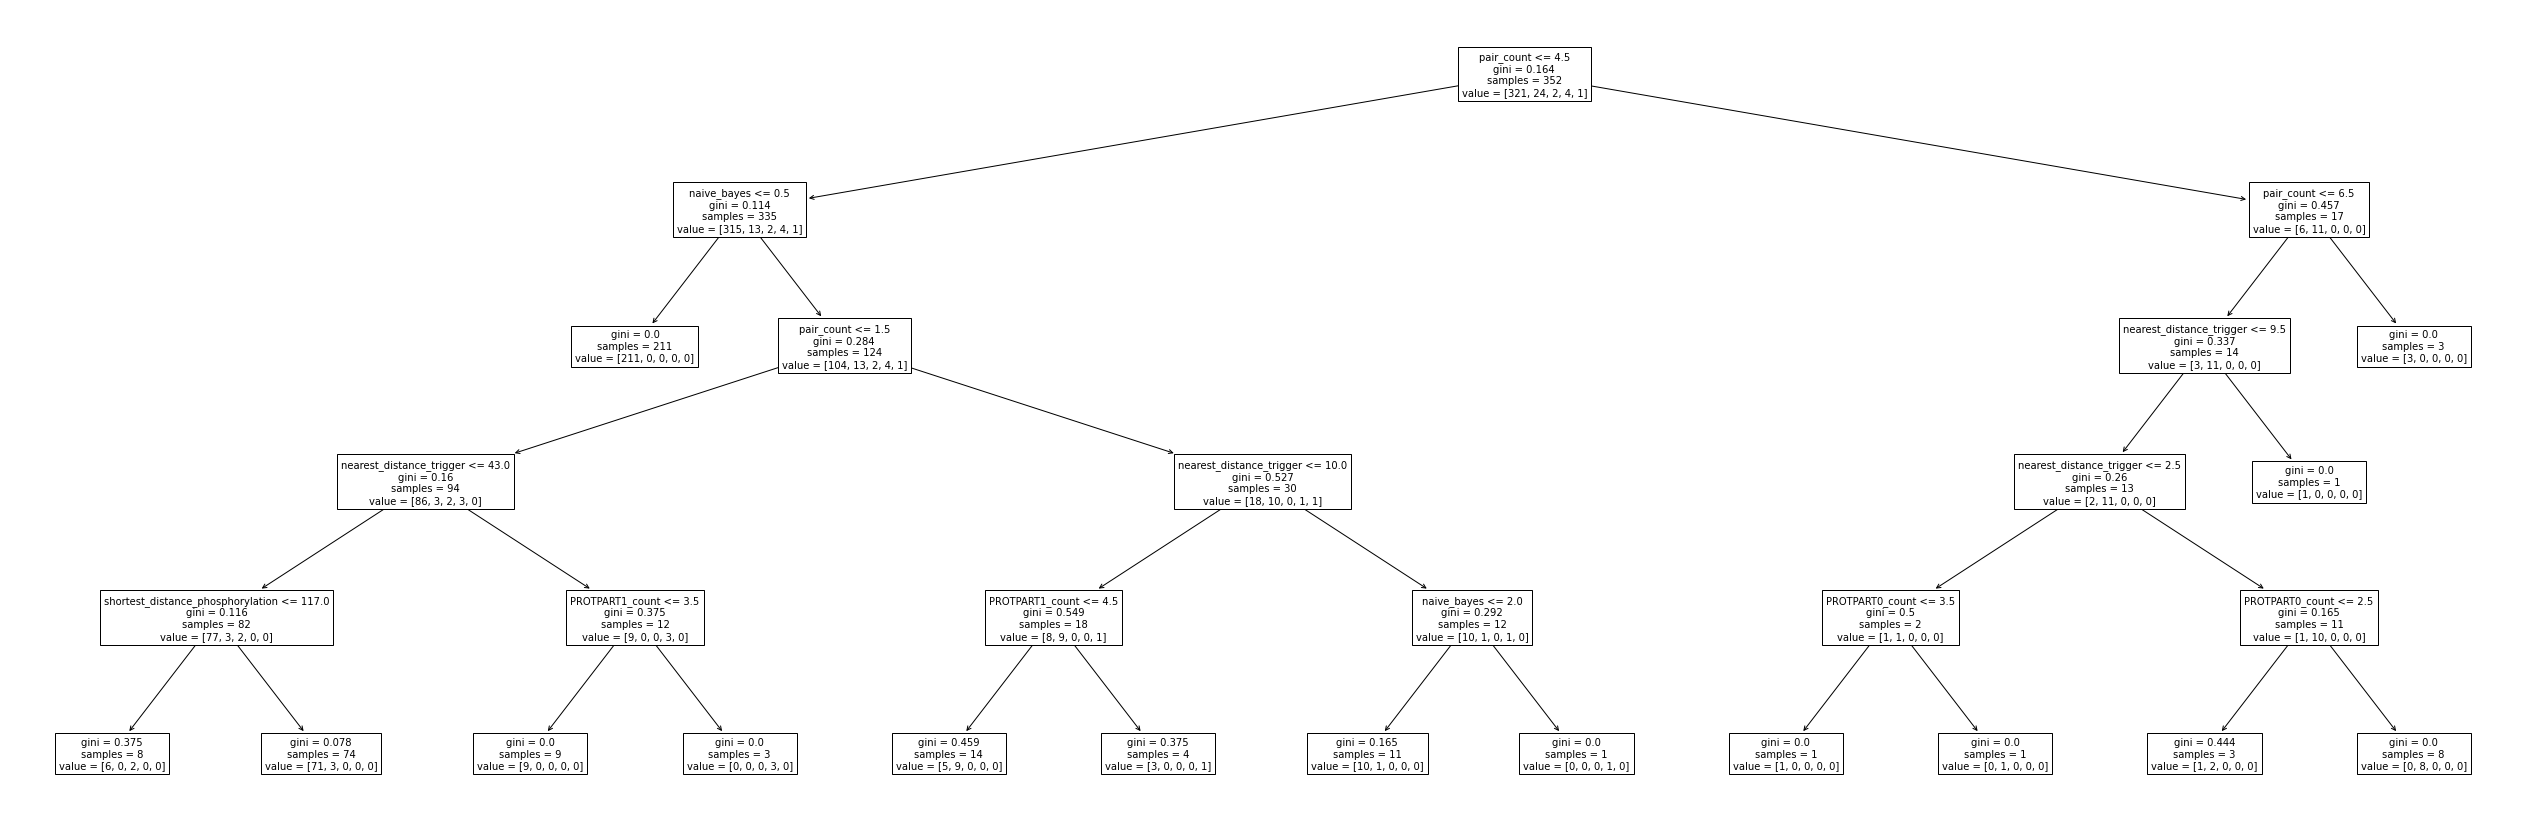

              precision    recall  f1-score   support

           1       0.77      0.83      0.80        24
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.80      0.77      0.79        31
   macro avg       0.29      0.31      0.30        31
weighted avg       0.72      0.77      0.75        31

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       321
           1       0.77      0.83      0.80        24
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.96

In [16]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file)

t_m, df_test_prediction["shortcut_pred"] = train_and_predict(df_test_prediction, min_df=1)

plot_tree(t_m)


print_report(df_test_prediction["y"], df_test_prediction["shortcut_pred"], False, pos_labels)

print_report(df_test_prediction["y"], df_test_prediction["shortcut_pred"], False, all_labels)

## Fit large scale hq

(5794, 11)
(5794, 11)


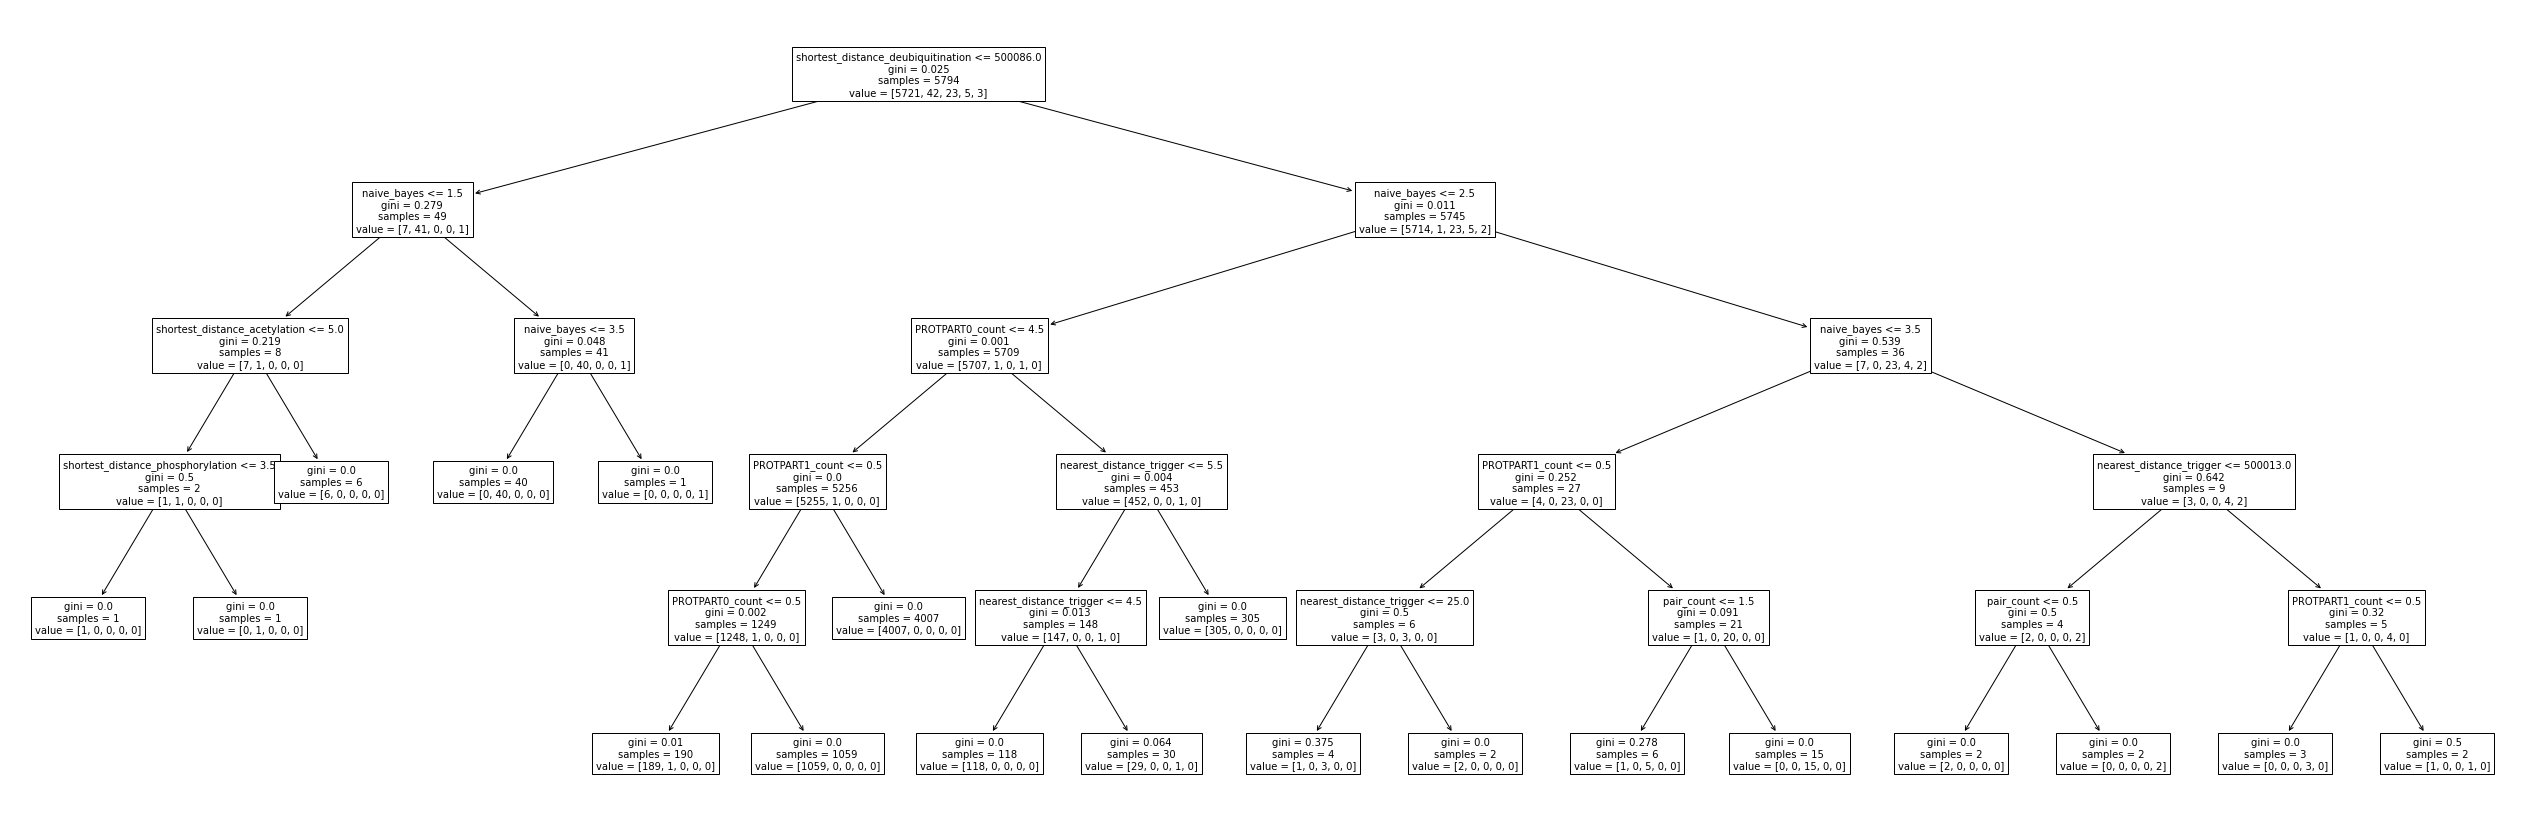

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5721
           2       1.00      0.98      0.99        42
           3       0.92      1.00      0.96        23
           4       1.00      0.60      0.75         5
           5       1.00      1.00      1.00         3
           6       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00      5794
   macro avg       0.82      0.76      0.78      5794
weighted avg       1.00      1.00      1.00      5794

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      5721
           2       1.00      0.98      0.99        42
           3       0.92      1.00      0.96        23
           4       1.00      0.60      0.75         5
           5       1.00      1.00      1.00         3
           6       0.00      0.00      0.00         0

   micro avg       1.00

In [17]:
df_largescale_hq = load_large_scale(largescalefile)
largescale_hq_m, df_largescale_hq["shortcut_pred"] = train_and_predict(df_largescale_hq)
plot_tree(largescale_hq_m)


print_report(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"], False, pos_labels)

print_report(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"], False, all_labels)



In [18]:
print_report(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"], latex=True)



              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5721
           2       1.00      0.98      0.99        42
           3       0.92      1.00      0.96        23
           4       1.00      0.60      0.75         5
           5       1.00      1.00      1.00         3

    accuracy                           1.00      5794
   macro avg       0.98      0.92      0.94      5794
weighted avg       1.00      1.00      1.00      5794



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.0
1,0.999476,0.999650,0.999563,5721.0
2,1.000000,0.976190,0.987952,42.0
3,0.920000,1.000000,0.958333,23.0
4,1.000000,0.600000,0.750000,5.0
5,1.000000,1.000000,1.000000,3.0
6,0.000000,0.000000,0.000000,0.0
micro avg,0.999137,0.999137,0.999137,5794.0
macro avg,0.702782,0.653692,0.670835,5794.0
weighted avg,0.999165,0.999137,0.999100,5794.0


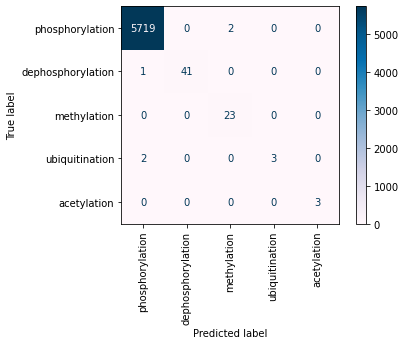

In [19]:
plot_confusionmatrix(df_largescale_hq["y"], df_largescale_hq["shortcut_pred"])

## Fit large scale low quality

In [20]:
df_low_quality = load_large_scale(largescale_low_hq)
df_low_quality["shortcut_pred"] = train_and_predict(df_low_quality)[1]



(6682, 11)
(6682, 11)


In [21]:
# Custom train
print_report(df_low_quality["y"], df_low_quality["shortcut_pred"])



              precision    recall  f1-score   support

           1       0.61      0.60      0.61      1674
           2       0.00      0.00      0.00       106
           3       0.50      0.61      0.55      1758
           4       0.59      0.54      0.57      1696
           5       0.65      0.61      0.63      1430
           6       0.92      0.61      0.73        18

    accuracy                           0.58      6682
   macro avg       0.55      0.50      0.51      6682
weighted avg       0.58      0.58      0.58      6682



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.0
1,0.614391,0.596774,0.605455,1674.0
2,0.000000,0.000000,0.000000,106.0
3,0.504677,0.613766,0.553901,1758.0
4,0.589662,0.544811,0.566350,1696.0
5,0.651232,0.609790,0.629830,1430.0
6,0.916667,0.611111,0.733333,18.0
micro avg,0.581413,0.581413,0.581413,6682.0
macro avg,0.468090,0.425179,0.441267,6682.0
weighted avg,0.578201,0.581413,0.577922,6682.0


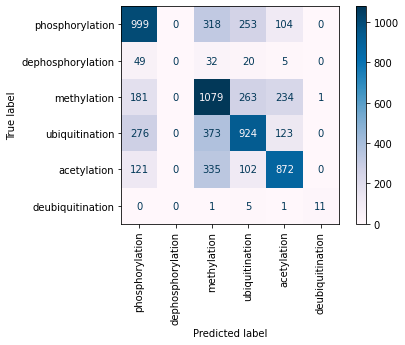

In [22]:
plot_confusionmatrix(df_low_quality["y"], df_low_quality["shortcut_pred"])

(5794, 11)
['phosphorylation', 'dephosphorylation', 'methylation', 'ubiquitination', 'acetylation']


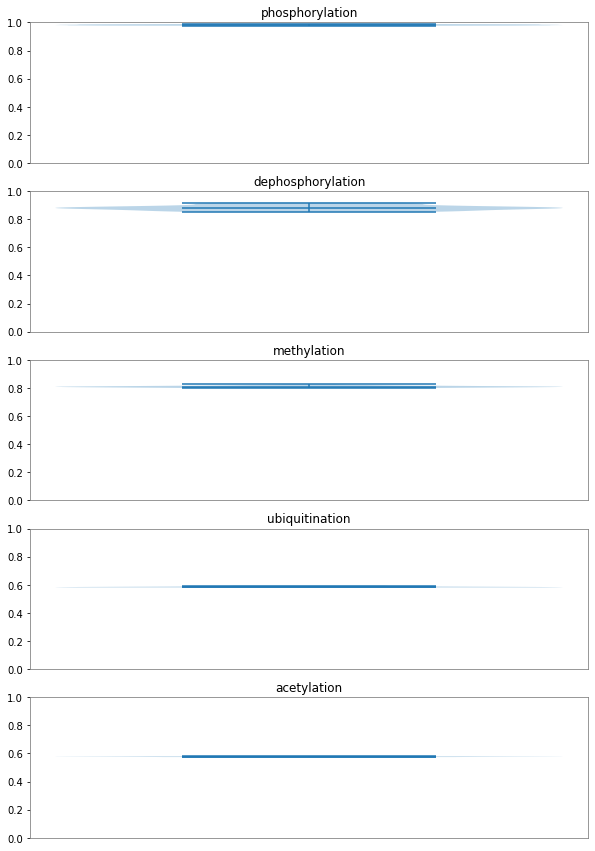

In [23]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    pred_class, pred_prob = m.predict(df["x"])
    df_t["nb_pred"] = pred_class
    df_t["nb_pred_conf"] = pred_prob
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


plot_confidence(prep_data(df_largescale_hq, largescale_hq_m))

plt.show()


